## Setup the notebook

In [1]:
import os, sys

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
    from kaggle_secrets import UserSecretsClient
    import subprocess
    
    user_secrets = UserSecretsClient()
    token = user_secrets.get_secret("git_token")
    
    repo_url = f"git+https://{token}@github.com/Blaku03/PitchAnalyzer_AI.git"
    
    subprocess.check_call(
        ["pip", "install", repo_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.STDOUT
    )
    video_path = "/kaggle/input/pitchtest/B1606b0e6_1 (91).mp4"
    output_path = "./output_video.avi"
else:
    # reloads the code during development
    %load_ext autoreload
    %autoreload 2
    # ensure project root (one level up) is on PATH
    ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if ROOT not in sys.path:
        sys.path.insert(0, ROOT)

    video_path = "../sample_data/B1606b0e6_1 (91).mp4"
    output_path = "../output_videos/output_video.avi"
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

## Import the model

In [2]:
from utils.import_models import ModelImporter
players_model = ModelImporter().download_player_model()

Model downloaded to /home/bbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detectionv1_1/1


## Sanity check on the first frame


0: 544x960 1 ball, 1 goalkeeper, 24 players, 1 referee, 32.8ms
1: 544x960 1 goalkeeper, 21 players, 2 referees, 32.8ms
2: 544x960 1 ball, 21 players, 2 referees, 32.8ms
3: 544x960 1 ball, 21 players, 1 referee, 32.8ms
4: 544x960 21 players, 1 referee, 32.8ms
5: 544x960 1 ball, 1 goalkeeper, 22 players, 1 referee, 32.8ms
6: 544x960 1 ball, 21 players, 1 referee, 32.8ms
7: 544x960 22 players, 32.8ms
8: 544x960 1 ball, 1 goalkeeper, 21 players, 2 referees, 32.8ms
9: 544x960 1 goalkeeper, 22 players, 1 referee, 32.8ms
Speed: 2.3ms preprocess, 32.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 21 players, 2 referees, 33.1ms
1: 544x960 22 players, 2 referees, 33.1ms
2: 544x960 20 players, 2 referees, 33.1ms
3: 544x960 1 ball, 20 players, 2 referees, 33.1ms
4: 544x960 1 ball, 20 players, 2 referees, 33.1ms
5: 544x960 20 players, 2 referees, 33.1ms
6: 544x960 1 ball, 20 players, 2 referees, 33.1ms
7: 544x960 1 ball, 20 players, 2 referees, 33.1ms
8: 544x960 1 

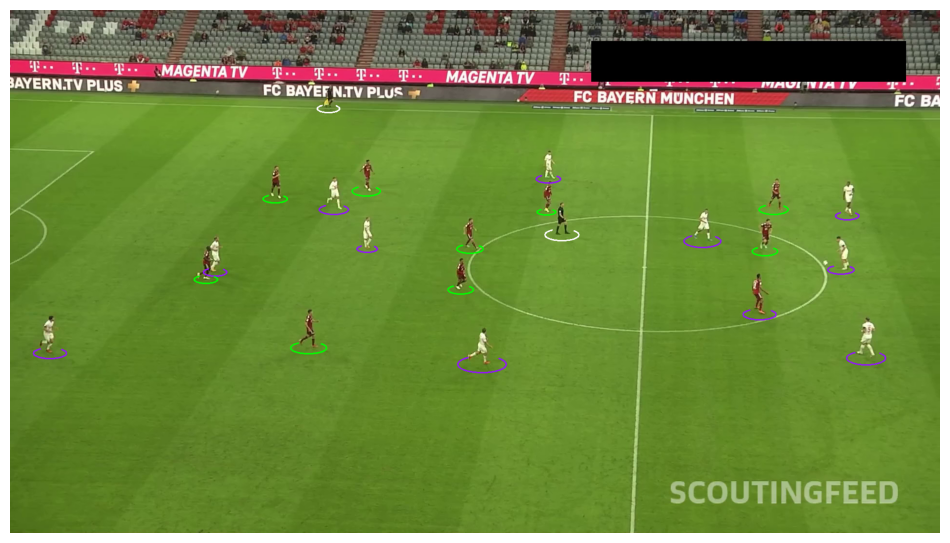

In [13]:
from annotators.player_annotator import PlayersAnnotator
from trackers.game_tracker import GameTracker
from utils.notebook_utils import show_image
from utils.video_utils import read_video

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_from_frames(frame_generator)

first_frame = next(frame_generator)
first_players_tracks = next(tracks_generator)

annotated_sample_image = PlayersAnnotator.annotate_frame(first_frame, first_players_tracks)
show_image(annotated_sample_image)

In [36]:
import cv2
import numpy as np

#source=https://stackoverflow.com/questions/27647424/opencv-puttext-new-line-character
def add_text_to_image(
    image_rgb: np.ndarray,
    label: str,
    top_left_xy: tuple = (0, 0),
    font_scale: float = 1,
    font_thickness: float = 1,
    font_face=cv2.FONT_HERSHEY_SIMPLEX,
    font_color_rgb: tuple = (0, 0, 255),
    bg_color_rgb: tuple | None = None,
    outline_color_rgb: tuple | None = None,
    line_spacing: float = 1,
):
    """
    Adds text (including multi line text) to images.
    You can also control background color, outline color, and line spacing.

    outline color and line spacing adopted from: https://gist.github.com/EricCousineau-TRI/596f04c83da9b82d0389d3ea1d782592
    """
    OUTLINE_FONT_THICKNESS = 3 * font_thickness

    im_h, im_w = image_rgb.shape[:2]

    for line in label.splitlines():
        x, y = top_left_xy

        # ====== get text size
        if outline_color_rgb is None:
            get_text_size_font_thickness = font_thickness
        else:
            get_text_size_font_thickness = OUTLINE_FONT_THICKNESS

        (line_width, line_height_no_baseline), baseline = cv2.getTextSize(
            line,
            font_face,
            font_scale,
            get_text_size_font_thickness,
        )
        line_height = line_height_no_baseline + baseline

        if bg_color_rgb is not None and line:
            # === get actual mask sizes with regard to image crop
            if im_h - (y + line_height) <= 0:
                sz_h = max(im_h - y, 0)
            else:
                sz_h = line_height

            if im_w - (x + line_width) <= 0:
                sz_w = max(im_w - x, 0)
            else:
                sz_w = line_width

            # ==== add mask to image
            if sz_h > 0 and sz_w > 0:
                bg_mask = np.zeros((sz_h, sz_w, 3), np.uint8)
                bg_mask[:, :] = np.array(bg_color_rgb)
                image_rgb[
                    y : y + sz_h,
                    x : x + sz_w,
                ] = bg_mask

        # === add outline text to image
        if outline_color_rgb is not None:
            image_rgb = cv2.putText(
                image_rgb,
                line,
                (x, y + line_height_no_baseline),  # putText start bottom-left
                font_face,
                font_scale,
                outline_color_rgb,
                OUTLINE_FONT_THICKNESS,
                cv2.LINE_AA,
            )
        # === add text to image
        image_rgb = cv2.putText(
            image_rgb,
            line,
            (x, y + line_height_no_baseline),  # putText start bottom-left
            font_face,
            font_scale,
            font_color_rgb,
            font_thickness,
            cv2.LINE_AA,
        )
        top_left_xy = (x, y + int(line_height * line_spacing))

    return image_rgb


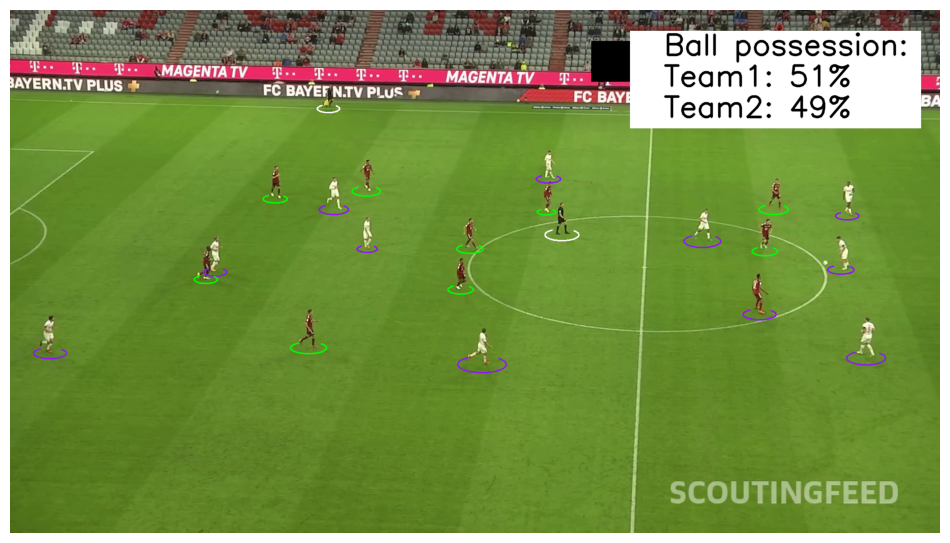

In [66]:
import supervision as sv

rect = sv.Rect(x=1280,y=45,width=600,height=200)

scene = sv.draw_filled_rectangle(scene=first_frame.copy(),rect=rect,color=sv.Color.WHITE)

text =  "Ball possession: \nTeam1: 51%\nTeam2: 49%"
scene = add_text_to_image(
    image_rgb=scene,
    label=text,
    font_thickness=3,
    font_scale=2,
    top_left_xy=(1350, 50),
    font_color_rgb=(0, 0, 0)
)

show_image(scene)

## Annotate the provided video

from utils.video_utils import save_video

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_from_frames(frame_generator)

frame_generator = read_video(video_path)
annotated_frames_generator = PlayersAnnotator.annotate_video(frame_generator, tracks_generator)
save_video(annotated_frames_generator, output_path)